In [1]:
import numpy as np


In [2]:
zstackin = np.load("D:/Antipa/Zemax/lenslets_longer_f=10_zstack_N=10.npy")

In [3]:
xdatain = np.load("D:/Antipa/Zemax/lenslets_longer_f=10_xinfo_N=10.npy")
zdatain = np.load("D:/Antipa/Zemax/lenslets_longer_f=10_z_N=10.npy")

In [4]:
zosgrdx = zstackin.shape[2]
grdpts = (np.r_[:zosgrdx]-np.int(zosgrdx/2))*xdatain[-1]*2/zosgrdx
px_zos = np.abs(grdpts[1]-grdpts[0])
print(grdpts[1]-grdpts[0])
px = .006;      #Miniscope pixel size in mm
FoV = np.max(grdpts)-np.min(grdpts)
print(FoV)
pxtarget = np.ceil(np.array([2.88, 4.51])/px)   #Miniscope exact size
dimtarget = pxtarget*px
xiy = (np.r_[:pxtarget[0]]-pxtarget[0]/2)*px
xix = (np.r_[:pxtarget[1]]-pxtarget[1]/2)*px
Xix, Xiy = np.meshgrid(xix,xiy)
xi = np.vstack((Xiy.ravel(),Xix.ravel())).T
print(xi.shape)
print(pxtarget[0]*pxtarget[1])

-0.003588864717031348
1.8339098704030112
(360960, 2)
360960.0


In [5]:
# Resample everything to be on a miniscope-sized grid with 6 micron pixels
import scipy as sc
from scipy import interpolate
from scipy import misc
print(dimtarget/px)
print(dimtarget)
print(xdatain[0])
zstack_copy = []
#
zstack_resamp = np.zeros((np.int(pxtarget[0]),np.int(pxtarget[1]),xdatain.shape[0]))
#for n in [0]:

for n in range(xdatain.shape[0]):

   # px_zos = np.abs(xdatain[n]/zstackin.shape[2])
    #grdptsx = (np.r_[:zosgrdx]-np.int(zosgrdx/2))*xdatain[-1]*2/zosgrdx
    #grdptsy = grdptsx
    #GrdptsX, GrdptsY = np.meshgrid(grdptsy,grdptsx)
    #print(np.shape(GrdptsX))
    #pts = np.vstack((GrdptsY.ravel(),GrdptsX.ravel())).T
    #print(np.shape(pts))
    #vals = zstackin[n,:,:].ravel()
    #interped = interpolate.griddata(pts,vals,xi,method='cubic',fill_value=0)
    #zstack_resamp[:,:,n] = np.reshape(interped,(np.int(pxtarget[0]),np.int(pxtarget[1])))
    print(n)
    xpad = np.int((dimtarget[1]-np.abs(FoV))/2/px_zos)
    ypad = np.int((dimtarget[0]-np.abs(FoV))/2/px_zos)
    zpad = np.pad(zstackin[n,:,:],((ypad,ypad),(xpad,xpad)),'constant',constant_values=(0,0))
    zresize = misc.imresize(zpad,pxtarget.astype(int),interp='bicubic').astype('float64')
    zresize = zresize/zresize.max()*zstackin[n,:,:].max()

    zstack_resamp[:,:,n] = zresize
    #zstack_copy.append()    
   # print("{:.2f}, {:.2f}".format(xpad,ypad))

[480. 752.]
[2.88  4.512]
-0.9647971160608166
0
1
2
3
4


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


5
6
7
8
9


4.415924297458809


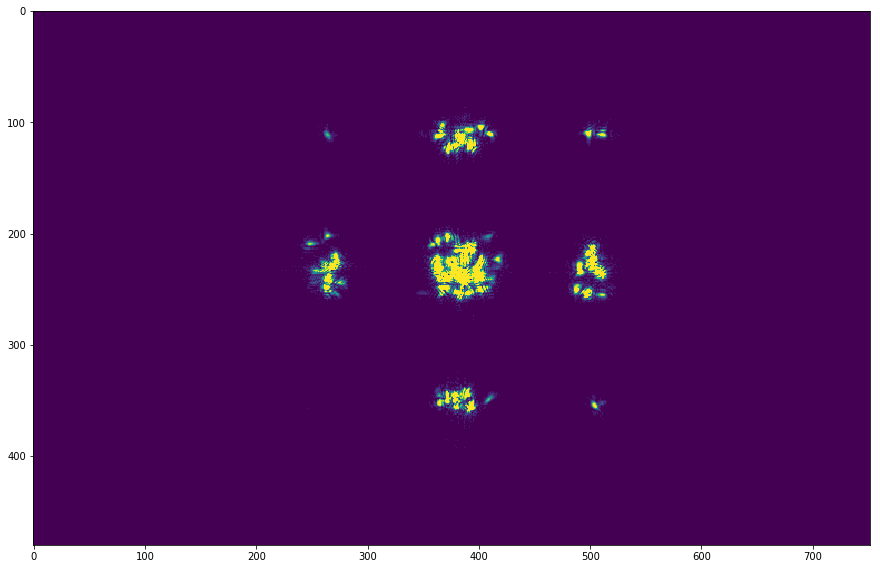

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.figure(figsize=(15,15))
#plt.imshow(np.reshape(interped,(480,752)),clim=(0,.3))
fig2 = plt.figure(figsize=(15,15))
plt.imshow(zresize,clim=(0,.3))
print(np.max(zstackin[n,:,:]))


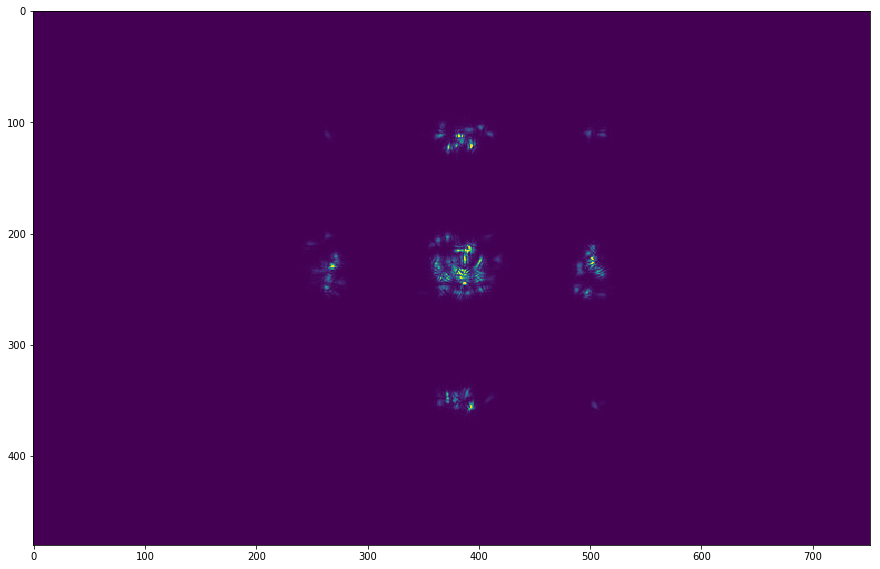

In [7]:
ims = []
fig = plt.figure(figsize=(15,15))
for n in range(zstack_resamp.shape[-1]):
    im = plt.imshow(zstack_resamp[:,:,n], interpolation='nearest', animated=True)
    plt.clim(0, np.percentile(zstack_resamp.ravel(), 99.99))
    ims.append([im])

In [8]:
import matplotlib.animation as animation
ani = animation.ArtistAnimation(fig, ims, interval=50, blit = True,
                                repeat_delay=10)
from IPython.display import HTML
HTML(ani.to_html5_video())

In [9]:

import numpy.linalg as la
# 
# coh = np.zeros((nz,nz))
# for refidx in range(nz):
#     ref = zstack_resamp[:,:,refidx]
#     for n in range(nz):
#         cur = zstack_resamp[:,:,n]
#         cohn = np.sum(cur*ref)/la.norm(cur,'fro')/la.norm(ref,'fro')
#         coh[refidx,n] = cohn
#         print("{:d} of {:d}".format(refidx*nz+n,nz**2))
#plt.imshow(coh)

In [10]:
nz = zstack_resamp.shape[-1]
hmat = np.zeros((zstack_resamp.shape[0]*zstack_resamp.shape[1],nz))
print(np.shape(hmat))
print(np.shape(zstack_resamp[:,:,n].ravel()))
for n in range(nz):
    hmat[:,n] = zstack_resamp[:,:,n].ravel()/la.norm(zstack_resamp[:,:,n],'fro')
    print(n)

(360960, 10)
(360960,)
0
1
2
3
4
5
6
7
8
9


In [11]:
HtH = np.matmul(hmat.T,hmat)

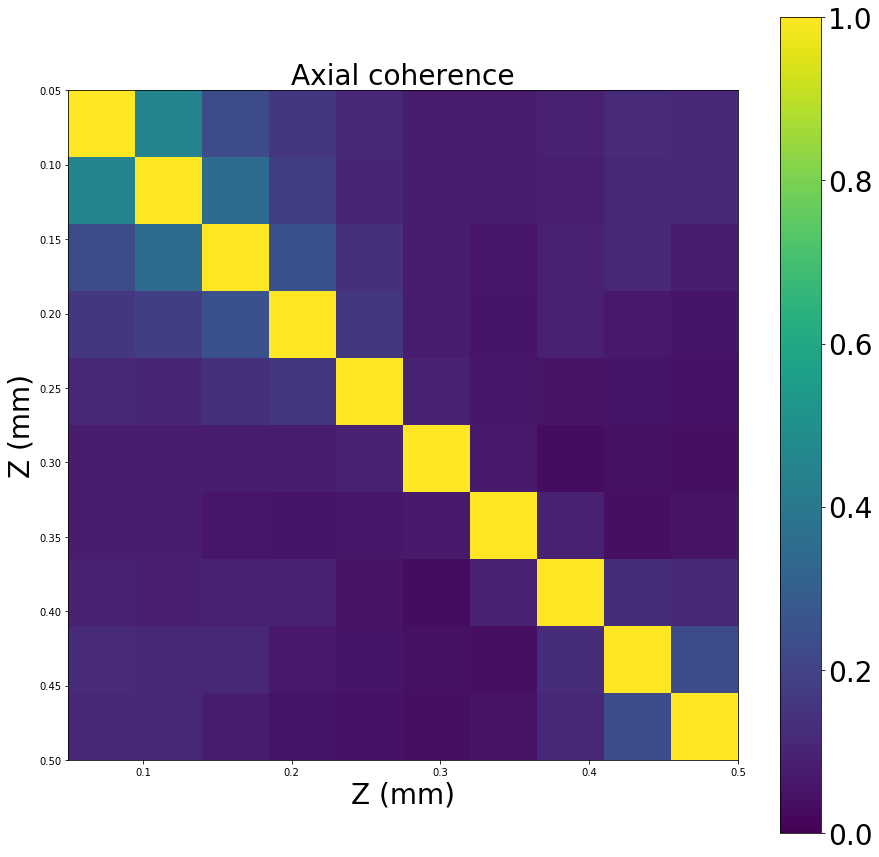

In [12]:
import matplotlib
fig = plt.figure(figsize=(15,15))
plt.imshow(HtH,interpolation='nearest',extent=[np.min(zdatain), np.max(zdatain), np.max(zdatain), np.min(zdatain)],clim=(0,1))
matplotlib.rcParams.update({'font.size': 28})
plt.title('Axial coherence',fontsize=28)
plt.xlabel('Z (mm)',fontsize=28)
plt.ylabel('Z (mm)',fontsize=28)
plt.colorbar()
plt.savefig("D:/Antipa/Zemax/Figs/lenslets_longer_f=10_axial_coherence.png")

In [13]:
import imageio
normfact = np.max(zstack_resamp)

for n in range(nz):
    imageio.imwrite("D:/Antipa/Zemax/Python/Zstacks/lenslets_longer_{:3d}.png".format(n),np.uint8(zstack_resamp[:,:,n]/normfact*255))

In [14]:
np.save("D:/Antipa/MaskDesigns/lenslets_longer_f=10_zstack",zstack_resamp)

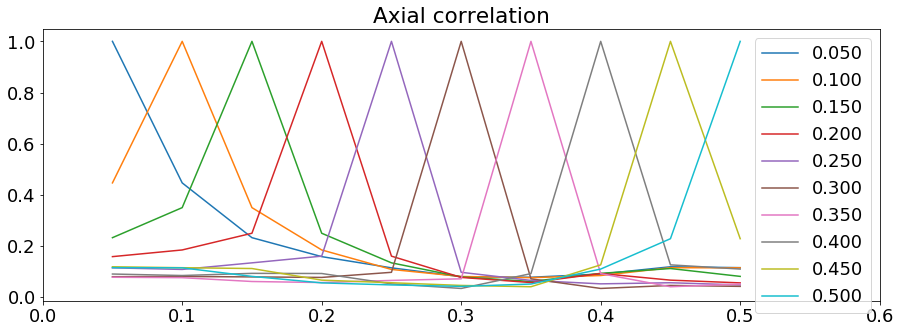

In [16]:
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(15,5))

for n in np.r_[:nz:1]:
    
    plt.plot(zdatain,HtH[:,n],label="{:.3f}".format(zdatain[n]))
    
plt.title('Axial correlation')
plt.xlim((0,.6))
plt.legend()
plt.savefig("D:/Antipa/Zemax/Figs/lenslets_longer_f=10_axial_corr_plots")

In [ ]:
plt.save?